In [15]:
from langchain import hub
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

import os
import faiss
from typing_extensions import List, TypedDict
from IPython.display import Image
from PIL import Image
import gradio as gr
import time
import warnings
warnings.filterwarnings('ignore')

# Walkthrough

## Setup

In [2]:
LANGSMITH_TRACING = "TRUE"
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

In [3]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [4]:
index = faiss.IndexHNSWFlat(768, 10) # (emb_size, n_neighbors)
vector_store = FAISS(embedding_function=embeddings,
                     index=index, # where to store the vectors
                     docstore=InMemoryDocstore(), # where to store documents metadata
                     index_to_docstore_id={} # how to map index to docstore
                    )

## Indexing

In [5]:
loader = PyMuPDFLoader("Pythia.pdf")
docs = loader.load_and_split()

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 150 sub-documents.


In [7]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['8594b238-7656-46dc-8114-82e45bd10675', 'dc508766-0b8a-4bd5-876c-191dee2f9a4c', '3449ff08-9718-4026-b488-328dea89739f']


## Retrieval and Generation

In [8]:
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


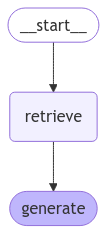

In [9]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [ ]:
result = graph.invoke({"question": "What are the sizes of the trained models?"})

print(f'Context: {result["context"]}\n\n----\n')
print(f'Answer: {result["answer"]}')

# Gradio Application

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vector_store = None
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
prompt = hub.pull("rlm/rag-prompt")

def reset_index():
    index = faiss.IndexHNSWFlat(768, 10)
    global vector_store
    vector_store = FAISS(embedding_function=embeddings,
                         index=index, # where to store the vectors
                         docstore=InMemoryDocstore(), # where to store documents metadata
                         index_to_docstore_id={} # how to map index to docstore
                        )
    return "Index Reset!" 

def indexing(files):
    try:
        docs = []
        for file in files:
            loader = PyMuPDFLoader(file.name)
            cur = loader.load_and_split()
            docs.extend(cur)
        
        all_splits = text_splitter.split_documents(docs)
        _ = vector_store.add_documents(documents=all_splits)
        return "PDFS indexed!"
    except Exception as e:
        print(e)
        return "Something went wrong :("

def chat(query, hist):
    hist.append(gr.ChatMessage(role="user", content=query))
    if vector_store.index.ntotal == 0:
        hist.append(gr.ChatMessage(role="assistant", content="Please upload and index your PDFS first !"))
    else:
        retrieved_docs = vector_store.similarity_search(query)
        if not retrieved_docs:  # Handle case where no docs are found
            hist.append(gr.ChatMessage(role="assistant", content="Sorry, I couldn't find any relevant info in the documents."))
        else:
            docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
            messages = prompt.invoke({"question": query, "context": docs_content})
            response = llm.invoke(messages)
            time.sleep(2)
            hist.append(gr.ChatMessage(role="assistant", content=response.content))
    return hist, ""

with gr.Blocks() as demo:
    gr.Markdown("# PDF RAG Chatbot")
    with gr.Row():
        with gr.Column():
            file_input = gr.File(label="Upload PDFS", file_types=[".pdf"], file_count="multiple")
            with gr.Row(equal_height=True):
                index_btn = gr.Button("Index PDFS")
                status = gr.Textbox(label="Status", value="No PDFs", interactive=False)
        with gr.Column():
            chatbot = gr.Chatbot(label="Chat with your pdfs",
                                 type="messages",
                                 show_copy_button=True,
                                 placeholder="What can i help with?")
            query_input = gr.Textbox(placeholder="Ask a question",
                                     show_label=False,
                                     submit_btn=True)
    index_btn.click(indexing, inputs=[file_input], outputs=[status])
    query_input.submit(chat, inputs=[query_input, chatbot], outputs=[chatbot, query_input])
    file_input.clear(reset_index, outputs=[status])

reset_index()
demo.launch()

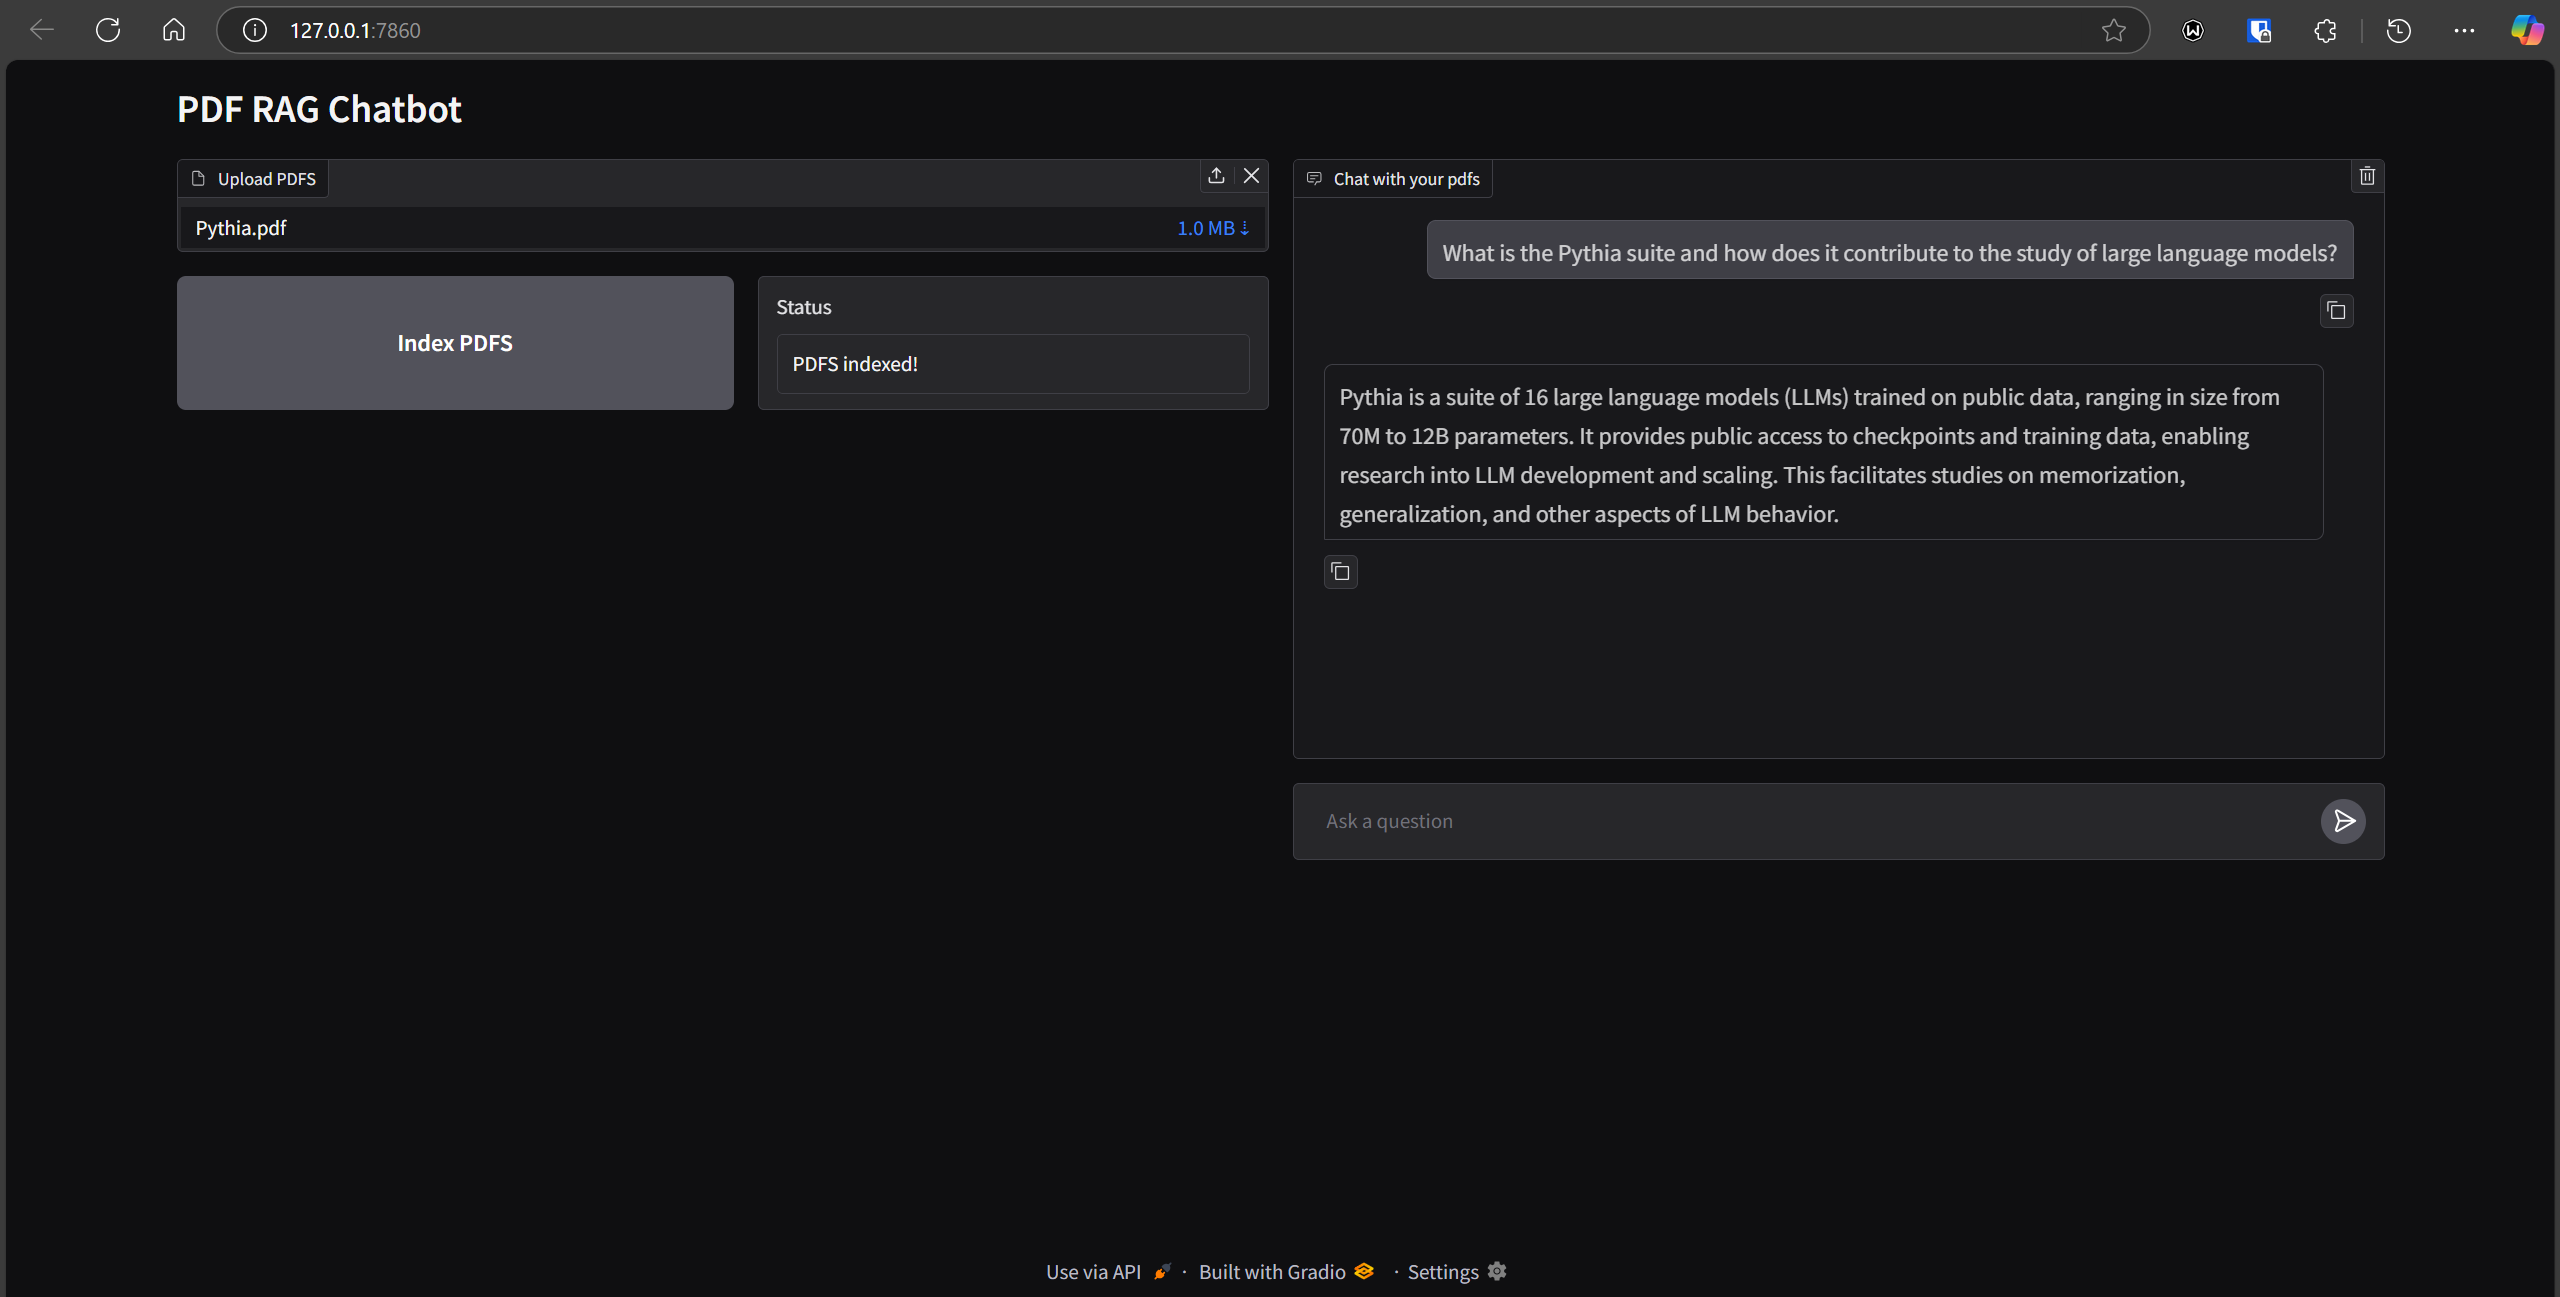

In [14]:
# test example
img = Image.open('test.png')
img